In [19]:
from langchain_core.messages import SystemMessage, HumanMessage
from langgraph.constants import END, START
from langgraph.graph import MessagesState, StateGraph
from langgraph.prebuilt import ToolNode

from module import get_module

In [20]:
module_client = get_module()

In [21]:
from langchain_core.tools import tool

@tool
def add(a: float, b: float) -> float:
    """Add the a and b"""
    print(f"Calling add {a}, {b}\n")
    return a + b

@tool
def planet_mass(planet: str) -> str:
    """Return the mass of a planet, args: planet name(capitalized), eg. Mercury"""
    print(f"Calling planet_mass {planet}\n")
    masses = {
        'Mercury': 0.3301,
        'Venus': 4.8557,
        'Earth': 5.9722,
        'Mars': 0.64169,
        'Jupiter': 1898.13,
        'Saturn': 568.32,
        'Uranus': 86.811,
        'Neptune': 102.409
    }
    return f"{planet} has a mess of {masses.get(planet, 0.0)} 10^24 KG"

tools = [add, planet_mass]
tools_by_name = { tool.name: tool for tool in tools }
module_with_tools = module_client.bind_tools(tools)

In [22]:
tools_by_name

{'add': StructuredTool(name='add', description='Add the a and b', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x108e531a0>),
 'planet_mass': StructuredTool(name='planet_mass', description='Return the mass of a planet, args: planet name(capitalized), eg. Mercury', args_schema=<class 'langchain_core.utils.pydantic.planet_mass'>, func=<function planet_mass at 0x108e6dc60>)}

In [23]:
def llm_call(state: MessagesState):
    return {
        'messages': [
            module_with_tools.invoke([
                SystemMessage(content='You are a a helpful assistant.')
            ] + state['messages'])
        ]
    }

tool_node = ToolNode(tools=tools)

# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState):
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "Action"
    return END

In [24]:
agent_builder = StateGraph(MessagesState)

agent_builder.add_node('llm_call', llm_call)
agent_builder.add_node('tools', tool_node)

agent_builder.add_edge(START, 'llm_call')
agent_builder.add_conditional_edges('llm_call', should_continue, {
    "Action": 'tools',
    END: END
})

agent_builder.add_edge("tools", 'llm_call')

agent = agent_builder.compile()

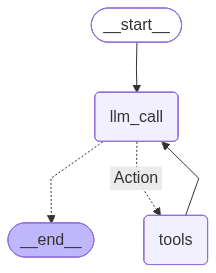

In [25]:
from IPython.display import Image, display

display(Image(agent.get_graph().draw_mermaid_png()))

In [26]:
messages = [HumanMessage(content="What is the combined mass of earth and jupiter")]
messages = agent.invoke({'messages': messages})
for m in messages['messages']:
    m.pretty_print()

Calling planet_mass Earth

Calling planet_mass Jupiter

Calling add 5.9722e+24, 1.89813e+27

================================ Human Message =================================

What is the combined mass of earth and jupiter
================================== Ai Message ==================================
Tool Calls:
  planet_mass (call_9xkQQqYeO5jWIEqajsBAWaOe)
 Call ID: call_9xkQQqYeO5jWIEqajsBAWaOe
  Args:
    planet: Earth
  planet_mass (call_m3LbAxkbfvnUf6VHbT4P1u0e)
 Call ID: call_m3LbAxkbfvnUf6VHbT4P1u0e
  Args:
    planet: Jupiter
================================= Tool Message =================================
Name: planet_mass

Earth has a mess of 5.9722 10^24 KG
================================= Tool Message =================================
Name: planet_mass

Jupiter has a mess of 1898.13 10^24 KG
================================== Ai Message ==================================
Tool Calls:
  add (call_OFZh023osmvKpnKl1VgMJy2Y)
 Call ID: call_OFZh023osmvKpnKl1VgMJy2Y
  Args:
    a